#### 1. 각자 포지션 추출 및 q1 이하값 제거
#### 2. pct 변수 생성
#### 3. 히스토그램 살펴보고, 지수함수꼴 분포 로그 변환
#### 4. 표준화 변환
#### 5. 각 포지션별 열 전처리 (제일 중요, pca성능 높이는 방법) 
#### 6. pca 분석 실시 
#### 7. pca 결과 인사이트 제시

In [7]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
import pandas as pd 
import numpy as np

In [3]:
df = pd.read_csv("D:/경기대/2학년_2학기/dna 동아리/23_겨울방학프로젝트/전처리csv/worldcup_passing.csv", encoding='utf-8')

In [ ]:
# 0: DF, 1: FW, 2: GK, 3: MF 

In [261]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(df['position'])
position = encoder.transform(df['position'])
position = pd.DataFrame(position)
position.columns = ['position']

### 1. 각자 포지션 추출 및 q1 이하값 제거

In [4]:
#포지션별 minutes 특정 사분위 제거 함수

def position_eda(n,df): #자기 포지션에 맞는 n번호 입력 
    
    if n == 1:
        df = df[df['position']=='GK']
    elif n == 2:
        df = df[df['position']=='DF']
    elif n == 3:
        df = df[df['position']=='MF']
    elif n == 4:
        df = df[df['position']=='FW']
    
    q1,q2,q3 = np.percentile(df['minutes'], [25,50,75]) #1,2,3사분위수
    iqr = q3-q1 
    lower_bound = q1 - (iqr * 1.5) #1사분위 이하 이상치
    upper_bound = q3 + (iqr * 1.5) #3사분위 이하 이상치
    middle_bound = q2 #중앙값
    
    df = df[df['minutes'] > q1] #여기에 원하는 분위수 넣으면됨 나는 이상치 넣은거 
    
    return(df) 

In [5]:
df = position_eda(1,df)
df = df.reset_index(drop=True) #인덱스 재정렬 필수!
df.head()

,player,position,team,age,birth_year,minutes,round,passes_completed,passes,passes_total_distance,...,passes_completed_medium,passes_medium,passes_completed_long,passes_long,assists,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes
0,Dominik Livaković,GK,Croatia,27,1995,693,semi finals,194,228,4572,...,81,81,43,76,0,0,3,0,0,0
1,Yassine Bounou,GK,Morocco,31,1991,567,semi finals,154,209,4346,...,82,84,43,94,0,0,0,0,0,0
2,Mathew Ryan,GK,Australia,30,1992,360,round of 16,113,164,3668,...,46,46,54,105,0,0,1,0,0,0
3,Shūichi Gonda,GK,Japan,33,1989,387,round of 16,68,113,1770,...,32,33,16,59,0,0,1,0,0,0
4,Kim Seung-gyu,GK,Korea Republic,32,1990,360,round of 16,93,128,2291,...,45,45,25,59,0,0,1,0,0,0


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

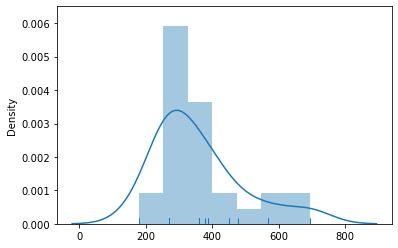

In [8]:
sns.distplot(x=df['minutes'], kde=True, rug=True)

### 2. pct 변수 생성 

In [9]:
def pca_data(df,n):
    
    #패스 성공률 변수 생성
    passes_pct = round(df.loc[:,'passes_completed'] / df.loc[:,'passes'],2)
    passes_pct = pd.DataFrame(passes_pct, columns=['passes_pct'])
    df['passes_pct'] = passes_pct

    #롱패스 성공률 변수 생성
    long_passes_pct = round(df.loc[:,'passes_completed_long'] / df.loc[:,'passes_long'],2)
    long_passes_pct = pd.DataFrame(long_passes_pct, columns=['long_passes_pct'])
    df['long_passes_pct'] = long_passes_pct
    
    #미디움 패스 성공률 변수 생성
    medium_passes_pct = round(df.loc[:,'passes_completed_medium'] / df.loc[:,'passes_medium'],2)
    medium_passes_pct = pd.DataFrame(medium_passes_pct, columns=['medium_passes_pct'])
    df['medium_passes_pct'] = medium_passes_pct

    #패스 성공(성공률 아님!) 관련 변수 삭제     
    #df = df[df.columns.drop(list(df.filter(regex='completed')))]
    
    return(df)

In [10]:
df = pca_data(df,7)

### 3. 히스토그램 시각화
#### 지수함수꼴을 띄는 열 로그변환 

In [11]:
df_eda = df.drop(columns=['player','position','team','age','birth_year','round','minutes'],axis=1)

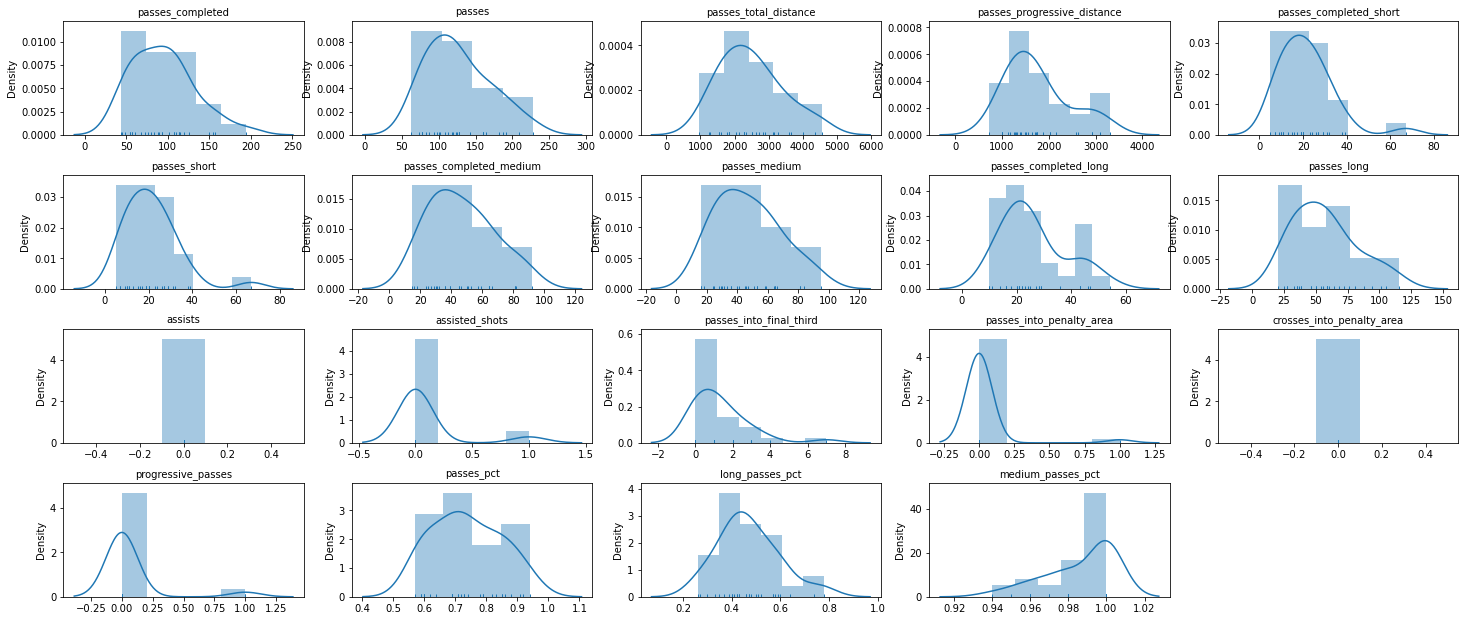

In [12]:
import warnings
warnings.filterwarnings( 'ignore' )

plt.figure(figsize=(25, 10)) # 가로, 세로 
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

for i in range(len(df_eda.columns)):
  col = df_eda.columns[i]

  plt.subplot(4, 5, i+1)
  sns.distplot(x=df_eda[col], kde=True, rug=True)
  plt.title(col, fontsize=10)

#### pct 관련 변수 제외 모든 열 로그변환 


In [13]:
#로그변환 이전, 결측치 및 무한대로 발산하는 값 제거 
df_eda = df_eda.fillna(0)
df_eda = df_eda.replace([np.inf, -np.inf], 0) #inf값을 nan으로 대체 후 0으로 처리 

In [14]:
#로그변환 
df_eda.iloc[:,:16] = np.log1p(df_eda.iloc[:,:16])

In [15]:
df_eda.head()

,passes_completed,passes,passes_total_distance,passes_progressive_distance,passes_completed_short,passes_short,passes_completed_medium,passes_medium,passes_completed_long,passes_long,assists,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes,passes_pct,long_passes_pct,medium_passes_pct
0,5.273000,5.433722,8.427925,8.105308,4.219508,4.219508,4.406719,4.406719,3.784190,4.343805,0.0,0.0,1.386294,0.0,0.0,0.0,0.85,0.57,1.00
1,5.043425,5.347108,8.377241,8.039802,3.401197,3.401197,4.418841,4.442651,3.784190,4.553877,0.0,0.0,0.000000,0.0,0.0,0.0,0.74,0.46,0.98
2,4.736198,5.105945,8.207674,7.855545,2.639057,2.639057,3.850148,3.850148,4.007333,4.663439,0.0,0.0,0.693147,0.0,0.0,0.0,0.69,0.51,1.00
3,4.234107,4.736198,7.479300,7.171657,3.044522,3.044522,3.496508,3.526361,2.833213,4.094345,0.0,0.0,0.693147,0.0,0.0,0.0,0.60,0.27,0.97
4,4.543295,4.859812,7.737180,7.249926,3.178054,3.178054,3.828641,3.828641,3.258097,4.094345,0.0,0.0,0.693147,0.0,0.0,0.0,0.73,0.42,1.00


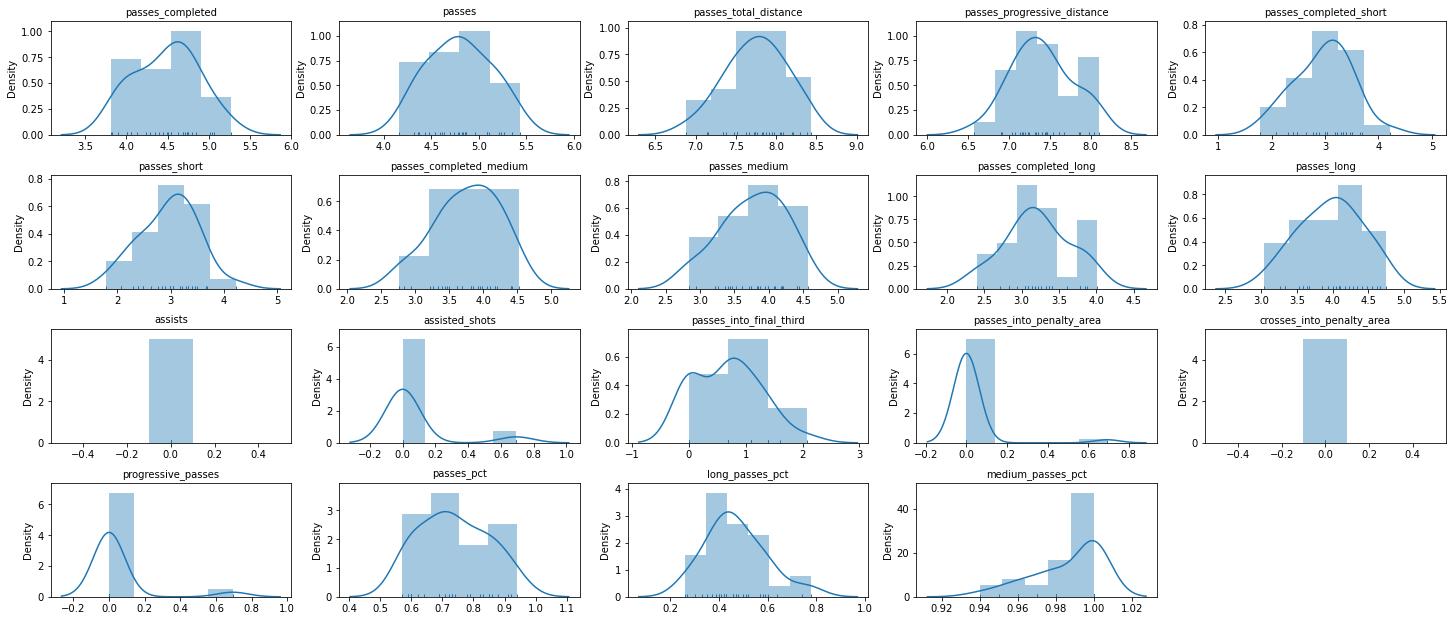

In [16]:
#로그변환 여부 재시각화 
import warnings
warnings.filterwarnings( 'ignore' )

plt.figure(figsize=(25, 10)) # 가로, 세로 
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

for i in range(len(df_eda.columns)):
  col = df_eda.columns[i]

  plt.subplot(4, 5, i+1)
  sns.distplot(x=df_eda[col], kde=True, rug=True)
  plt.title(col, fontsize=10)

#### 대부분의 값이 로그 변환 잘되었음 
#### 로그변환을 실시한 열에 대해 잘안됐거나, 값이 하나만 가지고있으면 제거 고려

#### GK의 경우, 'assists','assisted_shots','passes_into_penalty_area','crosses_into_penalty_area','progressive_passes' 제거 고려

In [17]:
df_eda = df_eda.drop(columns=['assists','assisted_shots','passes_into_penalty_area',
                              'crosses_into_penalty_area','progressive_passes'], axis=1)

### 4. 표준환 변환

In [18]:
# 표준화

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scale = pd.DataFrame(scaler.fit_transform(df_eda), columns=df_eda.columns, index = df_eda.index)

### 5. 각 포지션별 열 전처리 (제일 중요!)
#### 상관행렬, 분포도 봤을때, 필요없어보이는 열 정리 필요
#### 로그변환을 위에서 했는데도 분포가 정규분포가 아니거나 하나의 값에 치우친 경우,
#### 상관이 터무니없이 낮거나 너무 높은 경우 제거 필요
#### 아래 변수 삭제 과정을 반복하면서 각 포지션별 기여율을 높일 수 있는 최적의 조합 찾아서 사용! 
#### 지금 내가 삭제한건 골키퍼 파트라서 다른 포지션으로 하면 낮을 수 있음!

#### 변수 삭제하는 과정 반복할때 처음부터 다시 불러올 필요없고, 위에 표준화한거만 다시 불러서 하면댐!

<AxesSubplot:title={'center':'pass_type'}>

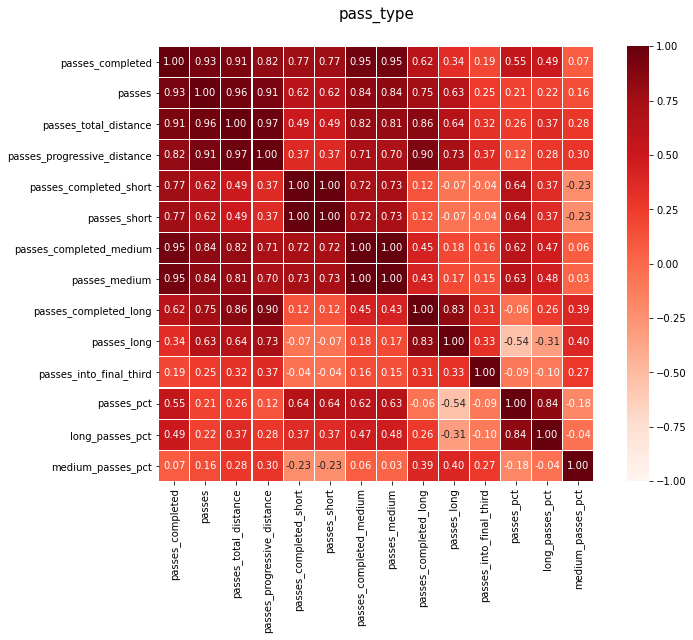

In [19]:
plt.figure(figsize=(12, 8))
plt.title("pass_type", y = 1.05, size = 15)

sns.heatmap(df_scale.corr(), 
            linewidths = 0.1, #셀 사이 선을 집어넣음 
            vmax = 1.0, #최댓값 
            vmin = -1.0, #최솟값 
            square = True, 
            cmap = 'Reds',#맵 색깔
            linecolor = "white", #셀 사이 라인 색깔 
            annot = True, #각 셀의 표기 유무 및 그 값의 데이터타입 설정 
            fmt = '.2f', #각 셀의 값의 데이터 형태 (만약 소수2째자리까지 한다면 '.2f')
            annot_kws = {"size" : 10} #셀 안의 폰트 크기
           )

In [25]:
#변수 삭제 과정 

#df_scale = df_scale[df_scale.columns.drop(list(df_scale.filter(regex='pct')))]
df_scale = df_scale.drop(columns=['passes_completed','passes_completed_short', 'passes_completed_medium',
                                'passes_completed_long', 'passes_total_distance'],axis=1)

### 6. PCA 분석
#### 보고서에 넣어야할 내용: 기여율과 누적기여율, pca1과 2의 고유벡터 및 변수중요도, pca1과 2의 의미해석

In [20]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components=6)
printcipalComponents = pca.fit_transform(df_scale)

principalDf = pd.DataFrame(data=printcipalComponents, 
                           columns = [f"pca{num+1}" for num in range(6)])
# 주성분으로 이루어진 데이터 프레임 구성

In [27]:
pca_data = pd.DataFrame({'고윳값': pca.explained_variance_,
                        '기여율': pca.explained_variance_ratio_},
                       index=np.array([f"pca{num+1}" for num in range(6)]))
pca_data['누적 기여율'] = pca_data['기여율'].cumsum()
pca_data

,고윳값,기여율,누적 기여율
pca1,0.256009,0.400192,0.400192
pca2,0.198195,0.309817,0.710009
pca3,0.079366,0.124065,0.834074
pca4,0.060603,0.094735,0.928809
pca5,0.030214,0.047231,0.976040
pca6,0.011202,0.017510,0.993550


In [28]:
a = np.round(pca.components_[0],3)
a = a.tolist()
b = np.round(pca.components_[1],3)
b = b.tolist()

pca_data = {'pca1' : a, 'pca2' : b}
df_pca = pd.DataFrame(pca_data, index= df_scale.columns)
df_pca

,pca1,pca2
passes,0.470,0.188
passes_progressive_distance,0.408,0.256
passes_short,0.325,-0.188
passes_medium,0.513,-0.077
passes_long,0.164,0.512
passes_into_final_third,0.144,0.307
passes_pct,0.347,-0.499
long_passes_pct,0.263,-0.303
medium_passes_pct,0.080,0.402


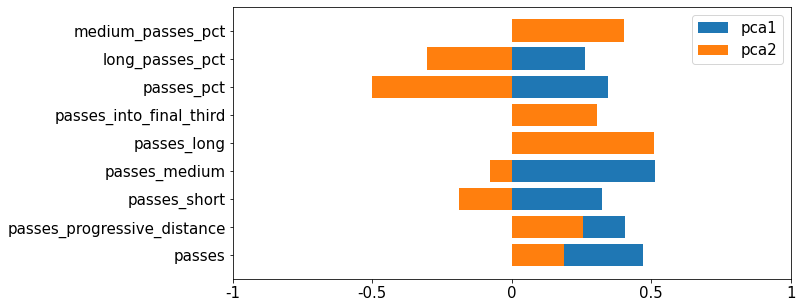

In [29]:
df_pca = df_pca.reset_index()
index = df_pca['index']
pca1 = df_pca['pca1']
pca2 = df_pca['pca2']

plt.figure(figsize=(10, 5))
plt.rcParams['font.size'] = 15
plt.barh(index,pca1,label='pca1')
plt.barh(index,pca2,label='pca2')
plt.xticks([-1,-0.5,0,0.5,1],('-1','-0.5','0','0.5','1'))
plt.legend()
plt.show()

#### pca1: 패스를 많이 하고, 그 중에서 짧은 패스, 중간 패스를 많이한 그룹
#### pca2: 파이널서드로 패스, 롱패스를 많이한 그룹. 패스 정확도는 떨어지는 그룹 

### 7. PCA 결과 인사이트 제시

In [30]:
df_info1 = df.iloc[:,0:3] 
df_info2 = df.iloc[:,5:7]
df_col = df.iloc[:,7:]

result1 = pd.concat([df_info1, df_info2], axis=1)
result2 = pd.concat([result1, principalDf.iloc[:,:2]], axis=1)
result = pd.concat([result2,df_col], axis=1)
result = result.reset_index(drop=True)

In [31]:
result.sort_values(by='pca1',ascending=False).head(5)

,player,position,team,minutes,round,pca1,pca2,passes_completed,passes,passes_total_distance,...,passes_long,assists,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes,passes_pct,long_passes_pct,medium_passes_pct
0,Dominik Livaković,GK,Croatia,693,semi finals,1.036803,0.184366,194,228,4572,...,76,0,0,3,0,0,0,0.85,0.57,1.00
12,Andries Noppert,GK,Netherlands,477,quarter finals,0.717848,0.050795,157,192,3993,...,81,0,0,0,0,0,0,0.82,0.58,1.00
7,Unai Simón,GK,Spain,387,round of 16,0.684071,-0.842808,150,160,3167,...,27,0,0,0,0,0,1,0.94,0.74,0.97
1,Yassine Bounou,GK,Morocco,567,semi finals,0.627060,0.159485,154,209,4346,...,94,0,0,0,0,0,0,0.74,0.46,0.98
11,Jordan Pickford,GK,England,450,quarter finals,0.480406,0.143076,126,160,3259,...,60,0,0,2,0,0,0,0.79,0.47,1.00


In [421]:
#데이터 저장 
result.to_csv('gk_pca.csv',index=False, encoding='utf-8')

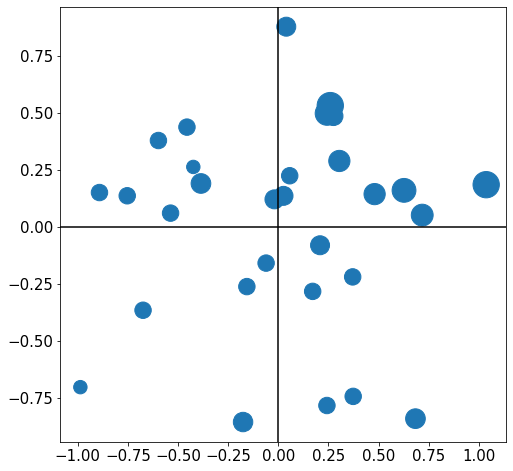

In [32]:
plt.figure(figsize=(8, 8))

plt.scatter(result['pca1'], result['pca2'],s=result['minutes'])
plt.axvline(x=0, color = 'black') 
plt.axhline(y=0, color = 'black')